# Đọc và tiền xử lí dữ liệu

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Chuẩn bị dữ liệu
data = pd.read_csv('ACB Historical Data.csv', index_col='Date', parse_dates=True)

# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data = data.reset_index(drop=True)

data

,Price,Open,High,Low,Vol.,Change %
0,10537.7,10477.8,10567.6,10417.9,7360000,0.0086
1,10926.9,10537.7,10956.8,10537.7,9450000,0.0369
2,10477.8,10956.8,10956.8,10477.8,8189999,-0.0411
3,10447.9,10447.9,10627.5,10328.1,9810000,-0.0029
4,10837.1,10447.9,10837.1,10447.9,8300000,0.0373
...,...,...,...,...,...,...
1373,21450.0,21650.0,21650.0,21350.0,4290000,-0.0046
1374,21600.0,21500.0,21600.0,21400.0,7970000,0.0070
1375,21650.0,21650.0,21900.0,21600.0,8029999,0.0023
1376,21700.0,21650.0,21700.0,21550.0,5410000,0.0023


# Phân chia dữ liệu

In [2]:
price = data['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test validate
train_size = int(len(price_scaled) * 0.75)
test_size = int(len(price_scaled) * 0.15)
val_size = len(price_scaled) - train_size - test_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]
val_data = price_scaled[train_size+test_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)
X_val, Y_val = create_dataset(val_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Xây dựng mô hình và train 

In [3]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_val, Y_val))

Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.0525 - val_loss: 0.0314
Epoch 2/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0028 - val_loss: 0.0056
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 6/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 7/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 8/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 9/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 10/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0026 - val_loss: 0.0050

16/16 [==============================] - 0s 29ms/step - loss: 8.9541e-04 - val_loss: 0.0018
Epoch 82/100
16/16 [==============================] - 0s 26ms/step - loss: 9.9100e-04 - val_loss: 0.0016
Epoch 83/100
16/16 [==============================] - 0s 28ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 84/100
16/16 [==============================] - 0s 31ms/step - loss: 7.5949e-04 - val_loss: 0.0024
Epoch 85/100
16/16 [==============================] - 0s 30ms/step - loss: 7.7843e-04 - val_loss: 0.0015
Epoch 86/100
16/16 [==============================] - 0s 25ms/step - loss: 8.5284e-04 - val_loss: 0.0017
Epoch 87/100
16/16 [==============================] - 0s 25ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 88/100
16/16 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 89/100
16/16 [==============================] - 0s 25ms/step - loss: 8.8991e-04 - val_loss: 0.0015
Epoch 90/100
16/16 [==============================] - 0s 25ms/step - loss: 9.734

# Dự báo trên tập test / validate và đánh giá mô hình

In [4]:
# Dự báo
test_predict = model.predict(X_test)
val_predict = model.predict(X_val)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
val_predict = scaler.inverse_transform(val_predict)
Y_val = scaler.inverse_transform([Y_val])

4/4 [==============================] - 0s 3ms/step


In [5]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 882.0793346690535
MAPE trên tập test là: 2.99077826604379 %
MDA trên tập test là: 47.42857142857143 %


# Dự báo 30 ngày tiếp theo

In [6]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 20ms/step
[[22641.309]
 [22679.414]
 [22745.324]
 [22677.19 ]
 [22550.69 ]
 [22376.955]
 [22121.28 ]
 [21760.127]
 [21307.004]
 [21687.902]
 [22265.408]
 [23087.344]
 [23521.48 ]
 [23739.477]
 [23935.178]
 [24118.629]
 [24271.998]
 [24380.273]
 [24439.092]
 [24496.977]
 [24567.777]
 [24486.11 ]
 [24277.893]
 [24142.178]
 [24119.824]
 [24232.229]
 [24480.814]
 [24873.734]
 [25422.896]
 [26126.123]]


# Chuyển các chuỗi np thành dataframe để vẽ đồ thị

In [7]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

val_predict_df = pd.DataFrame(val_predict)
val_predict_index = range(len(train_data)+len(test_data)+look_back, len(train_data)+len(test_data)+look_back+len(val_predict))
val_predict_df.index = val_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['Price']]
test_data_df = data[train_size:train_size + test_size][['Price']]
val_data_df = data[train_size+test_size:][['Price']]

# Vẽ đồ thị

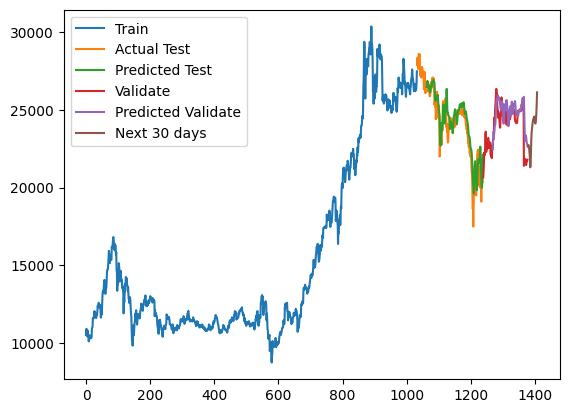

In [8]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(val_data_df, label='Validate')
plt.plot(val_predict_df, label='Predicted Validate')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()